# Clasificador de tweets.

Dado el siguiente conjunto de datos

http://help.sentiment140.com/for-students/

Crear una red neuronal capaz de clasificar los tweets según la connotación del contenido (negativo/neutral/positivo).

Será necesario utilizar técnicas de Word Embedding para la codificación del contenido. Utilizar la librería keras para obtener una embedding matrix propia y comparar los resultados obtenidos con un embedding matrix preentrenado de tipo word2vec de vuestra elección.

Para las unidades de la red neuronal recurrente se han utilizado dos tipos diferentes Simple, y LSTM , para comparar los resultados obtenidos.

Comentarios sobre el data set:

Como habréis visto en la definción del problema existen tres clases diferentes. Pero estas tres clases, solo aparecen en los datos de testeo, no en los de entrenamiento. Por tanto la precisión será siempre menor. La solución sería obtener más datos o realizar un muestreo de los datos para generar de nuevo los conjuntos de entrenamiento y testeo, pero esta última solución podría producir un fenomeno de infrarrepresentación de la clase neutro. Es por eso que se ha optado por eliminar aquellas tuplas de clase neutro del conjunto de testeo y se ha planteado como un problema binario (positivo-negativo).

In [1]:
import flask
flask.__version__

'1.1.1'

In [2]:
import pandas as pd

In [3]:
#Tweets de entrenamiento.
tweets_train = './/data/traindatanormalized2.csv'

df_train = pd.read_csv(tweets_train)
df_train.Text=df_train.Text.astype(str)
df_train['Sentiment'] = df_train['Sentiment'].replace({0: 0, 4: 1})
df_train = df_train.sample(frac=1).reset_index(drop=True)
tweets_train = [tuple(x) for x in df_train.values]

#Tweets de prueba.
tweets_test = './/data/testdatanormalized2.csv'

df_test = pd.read_csv(tweets_test)
df_test.Text=df_test.Text.astype(str)
df_test = df_test.drop(df_test[df_test['Sentiment']==2].index)
df_test['Sentiment'] = df_test['Sentiment'].replace({0: 0, 4: 1})
tweets_test = [tuple(x) for x in df_test.values]

print('Número de Tweets de entrenamiento: {num}'.format(num=len(tweets_train)))
print('Número de Tweets de test: {num}'.format(num=len(tweets_test)))

Número de Tweets de entrenamiento: 1600000
Número de Tweets de test: 359


## Normalización
Los datos se han normalizado con este código pero en un archivo de tipo .py con spyder, ya que al tratar con un dataset tan ammplio, preferí normalizarlo y guardarlo, para posteriormente poder trabajar con el dataset ya normalizado.

* Para este ejemplo haremos uso de ***spaCy***, pero en este caso tenemos que utilizar (e importar) el modelo para Inglés. 

* Para ***normalizar*** los tweets realizaremos las siguientes acciones:
    1. Pasamos las frases a minúsculas.
    2. Eliminamos los signos de puntuación.
    3. Eliminamos las palabras con menos de 3 caracteres.
    4. Eliminamos las Stop-Words.
    5. Eliminamos las palabras que empiecen por '@' o 'http'.
    6. Pasamos la palabra a su lema.


* Todos estos pasos los vamos a realizar en una misma función:

:
    
    import spacy
    nlp = spacy.load('en_core_web_sm')

* Divido los datos en dos listas:
     * X_train: los tweets de entrenamiento.
     * y_train: target (polaridad) de entrenamiento.
     
:
    
    X_train = [doc[5] for doc in tweets_train]
    y_train = [doc[0] for doc in tweets_train]

* Realizamos la misma acción para los datos de test:
     * X_test: los tweets de test.
     * y_test: target (polaridad) de test.
     
:
    
    X_test = [doc[5] for doc in tweets_test]
    y_test = [doc[0] for doc in tweets_test]

* Normalizamos la lista de frases y devolvemos la misma lista de frases normalizada:

:
    
    def normalize(sentenses):
    
      for index, sentense in enumerate(sentenses): 
        
          sentense = nlp(sentense.lower()) 
          sentenses[index] = " ".join([word.lemma_ for word in sentense if (not word.is_punct) #Eliminamos signos.
                                     and (len(word.text) > 2) and (not word.is_stop) #Eliminamos palabras cortas.
                                     and (not word.text.startswith('@')) and (not word.text.startswith('http'))]) #Eliminamos @ y http.
                                     
* Normalizamos las frases:
                                     
       X_train = normalize(X_train)
       X_test = normalize(X_test)
       
* Y lo guardamos:
       
       df_train.to_csv('.//trainandtestdata/traindatanormalized.csv')
       df_test.to_csv('.//trainandtestdata/testdatanormalized.csv')

In [4]:
df_train = df_train.drop('Unnamed: 0', 1)
df_train.head(10)

,Sentiment,1,2,3,4,Text
0,0,2207205191,Wed Jun 17 07:37:34 PDT 2009,NO_QUERY,turdboy420,barely learn quot;abc alphabet song&quot parod...
1,0,1973460372,Sat May 30 11:11:27 PDT 2009,NO_QUERY,monicananz,pam gooood miss
2,1,2015301421,Wed Jun 03 04:17:23 PDT 2009,NO_QUERY,nevitsky,totally join reception
3,1,1972346610,Sat May 30 09:03:13 PDT 2009,NO_QUERY,bizzrock,love saturday run pick old college friend let ...
4,1,2184602030,Mon Jun 15 16:08:54 PDT 2009,NO_QUERY,Mooblr,hey new follower come introduce
5,0,1686703449,Sun May 03 06:28:18 PDT 2009,NO_QUERY,thoughtprinter,dislike science actually dislike study
6,0,1969449962,Sat May 30 00:04:29 PDT 2009,NO_QUERY,AndrewVassallo,rise amp shine second element miss anyway go j...
7,1,1985803184,Sun May 31 17:48:12 PDT 2009,NO_QUERY,mariahisazebra,check email
8,0,2286097474,Mon Jun 22 15:59:40 PDT 2009,NO_QUERY,lexytime,miss
9,1,2056645891,Sat Jun 06 11:31:47 PDT 2009,NO_QUERY,watudoinsammie,mmmm noodle


In [5]:
df_test = df_test.drop('Unnamed: 0', 1)
df_test.head(10)

,Sentiment,1,2,3,4,Text
0,1,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,love kindle2 cool fantastic right
1,1,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,read kindle2 love lee child good read
2,1,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,assesment kindle2 fucking rock
3,1,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,love kindle2 month look new big huge need remorse
4,1,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,fair kindle2 think perfect
5,1,8,Mon May 11 03:22:00 UTC 2009,kindle2,GeorgeVHulme,big happy kindle2
6,0,9,Mon May 11 03:22:30 UTC 2009,aig,Seth937,fuck economy hate aig non loan give ass
7,1,10,Mon May 11 03:26:10 UTC 2009,jquery,dcostalis,jquery new good friend
8,1,11,Mon May 11 03:27:15 UTC 2009,twitter,PJ_King,love twitter
9,1,12,Mon May 11 03:29:20 UTC 2009,obama,mandanicole,love obama make joke


In [6]:
# Divido los datos en dos listas 
#     X_train: los tweets de entrenamiento
#     y_train: target (polaridad) de entrenamiento
X_train = [doc[6] for doc in tweets_train]
y_train = [doc[1] for doc in tweets_train]

#Realizamos la misma acción para los datos de test. 
#     X_test: los tweets de test
#     y_test: target (polaridad) de test
X_test = [doc[6] for doc in tweets_test]
y_test = [doc[1] for doc in tweets_test]

In [7]:
print(X_train[0:5])

['barely learn quot;abc alphabet song&quot parody quot;twinkle twinkle lil star&quot pretty mind blow tell', 'pam gooood miss', 'totally join reception', 'love saturday run pick old college friend let sweet tea vodka start flow', 'hey new follower come introduce']


## Bolsa de palabras
* Escogemos las 500 palabras más frecuentes.
* Tokenizamos los datos de entrenamiento.
* Pasamos las palabras al número de veces que se encuentran en los tweets.



In [8]:
#Bolsa de palabras
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils

#Bolsa de palabras.
max_words = 500 #Escogemos las 500 más frecuentes.
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
#tokenizer.fit_on_texts(X_test)

X_matrix = tokenizer.texts_to_matrix(X_train, mode='count')
X_matrix_test = tokenizer.texts_to_matrix(X_test, mode='count')

#X_train = np.array(X_train)
#X_test = np.array(X_test)

# Codificación del Target
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

Using TensorFlow backend.


Ahora tenemos el target codificado en 0 para sentimiento negativo y 1 para el sentimiento positivo.

## Red Simple.
* Una vez creada la red mostramos su arquitectura:
    - 500 Neuronas de entrada
    - Capa 2: 20 Neuronas
    - Conexiones "capa de entrada -> Capa 2" = (500*20) + 20 = 10020 Conexiones
    - Capa 3: 10 Neuronas
    - Conexiones "Capa 2 -> Capa 3" = (20*10) + 10 = 210 Conexiones
    - Capa de salida: 1 Neuronas
    - Conexiones "Capa 3 -> Capa de salida" = (10*1) + 1 = 11 Conexiones

In [9]:
#Red Neuronal.
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout

np.random.seed(9)
model = Sequential() #Contenedor genérico.
model.add(Dense(20, activation='relu', input_dim=max_words))
model.add(Dropout(0.1))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                10020     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Entrenamos la red neuronal.
model.fit(X_matrix, y_train, batch_size=64, verbose=1, epochs=20, validation_split=0.1)

Train on 1440000 samples, validate on 160000 samples
Epoch 1/20
1440000/1440000 [==============================] - 83s 57us/step - loss: 0.5482 - accuracy: 0.7137 - val_loss: 0.5384 - val_accuracy: 0.7190
Epoch 2/20
1440000/1440000 [==============================] - 66s 46us/step - loss: 0.5402 - accuracy: 0.7192 - val_loss: 0.5360 - val_accuracy: 0.7207
Epoch 3/20
1440000/1440000 [==============================] - 68s 47us/step - loss: 0.5381 - accuracy: 0.7210 - val_loss: 0.5347 - val_accuracy: 0.7221
Epoch 4/20
1440000/1440000 [==============================] - 57s 40us/step - loss: 0.5370 - accuracy: 0.7218 - val_loss: 0.5345 - val_accuracy: 0.7228
Epoch 5/20
1440000/1440000 [==============================] - 60s 42us/step - loss: 0.5359 - accuracy: 0.7229 - val_loss: 0.5340 - val_accuracy: 0.7217
Epoch 6/20
1440000/1440000 [==============================] - 59s 41us/step - loss: 0.5352 - accuracy: 0.7229 - val_loss: 0.5342 - val_accuracy: 0.7229
Epoch 7/20
1440000/1440000 [=======

In [12]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

y_true = encoder.inverse_transform(y_train.reshape(-1))

print(y_true[0:5])

y_pred = model.predict_classes(X_matrix)
y_pred = encoder.inverse_transform(y_pred.reshape(-1))

print(y_pred[0:5])

print('Accuracy: {acc:0.4f}'.format(acc=accuracy_score(y_true=y_true, y_pred=y_pred)))
print('F1: {f1:0.4f}'.format(f1=f1_score(y_true=y_true, y_pred=y_pred, average='weighted')))
print('Precision: {pre:0.4f}'.format(pre=precision_score(y_true=y_true, y_pred=y_pred, average='weighted')))
print('Recall: {rec:0.4f}'.format(rec=recall_score(y_true=y_true, y_pred=y_pred, average='weighted')))
print(classification_report(y_true=y_true, y_pred=y_pred))
confusion_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1])

[0 0 1 1 1]
[1 0 1 1 1]
Accuracy: 0.7276
F1: 0.7272
Precision: 0.7291
Recall: 0.7276
              precision    recall  f1-score   support

           0       0.75      0.69      0.72    800000
           1       0.71      0.77      0.74    800000

    accuracy                           0.73   1600000
   macro avg       0.73      0.73      0.73   1600000
weighted avg       0.73      0.73      0.73   1600000



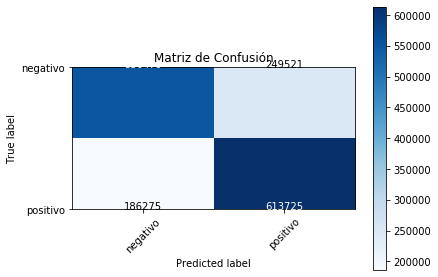

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure()
plot_confusion_matrix(confusion_matrix, classes=['negativo', 'positivo'],
                      title='Matriz de Confusión')
plt.show()

## Red Recurrente LSTM.

In [1]:
import pandas as pd

In [2]:
#Tweets de entrenamiento.
tweets_train = './/data/traindatanormalized2.csv'

df_train = pd.read_csv(tweets_train)
df_train.Text=df_train.Text.astype(str)
df_train['Sentiment'] = df_train['Sentiment'].replace({0: 0, 4: 1})
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train = df_train.drop('Unnamed: 0', 1)


#Tweets de prueba.
tweets_test = './/data/testdatanormalized2.csv'

df_test = pd.read_csv(tweets_test)
df_test.Text=df_test.Text.astype(str)
df_test = df_test.drop(df_test[df_test['Sentiment']==2].index)
df_test['Sentiment'] = df_test['Sentiment'].replace({0: 0, 4: 1})
df_test = df_test.drop('Unnamed: 0', 1)

print('Número de Tweets de entrenamiento: {num}'.format(num=len(df_train['Sentiment'])))
print('Número de Tweets de test: {num}'.format(num=len(df_test['Sentiment'])))

Número de Tweets de entrenamiento: 1600000
Número de Tweets de test: 359


In [3]:
#Bolsa de palabras
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils

#Bolsa de palabras.
max_words = 500 #Escogemos las 500 más frecuentes.
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_train['Text'].values)

# Codificación del Target
encoder = LabelEncoder()
encoder.fit(df_train['Sentiment'].values)
y_train = encoder.transform(df_train['Sentiment'].values)
y_test = encoder.transform(df_test['Sentiment'].values)

# Codificación del Target
#y_train = pd.get_dummies(df_train['Sentiment'].values)
print('Forma de las etiquetas del tensor:', y_train.shape)

#y_test = pd.get_dummies(df_test['Sentiment'].values)
print('Forma de las etiquetas del tensor:', y_test.shape)

Using TensorFlow backend.


Forma de las etiquetas del tensor: (1600000,)
Forma de las etiquetas del tensor: (359,)


Hasta ahora hemos realizado el mismo trabajo que haríamos para la red simple: 

Los datos han sido previeamente tratados, por eso se utiliza el archivo "traindatanormalized2" y "testdatanormalized2".
* Importamos los datos, separando una muestra para entrenar la red y otra para validar el entrenamiento.
* Creamos una bolsa de 500 palabras (se podrían escoger más, lo que aumentaría la precisión de la red, pero ralentiza todo el proceso).

In [4]:
from keras.preprocessing.sequence import pad_sequences

# documentos pad con una longitud máxima de 4 palabras
max_length = 250

X_train = tokenizer.texts_to_sequences(df_train['Text'].values)
X_test = tokenizer.texts_to_sequences(df_test['Text'].values)

X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 278068 unique tokens.


In [5]:
#Red Recurrente LSTM.
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Layer, SpatialDropout1D
from keras.callbacks import EarlyStopping

EMBEDDING_DIM = 100

model = Sequential()
model.add(Embedding(max_words, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          50000     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 130,602
Trainable params: 130,602
Non-trainable params: 0
_________________________________________________________________


In [7]:
epochs = 5
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

C:\Users\veral\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1440000 samples, validate on 160000 samples
Epoch 1/5
1440000/1440000 [==============================] - 10878s 8ms/step - loss: 0.5422 - accuracy: 0.7154 - val_loss: 0.5350 - val_accuracy: 0.7212
Epoch 2/5
1440000/1440000 [==============================] - 10665s 7ms/step - loss: 0.5343 - accuracy: 0.7213 - val_loss: 0.5320 - val_accuracy: 0.7248
Epoch 3/5
1440000/1440000 [==============================] - 10759s 7ms/step - loss: 0.5309 - accuracy: 0.7241 - val_loss: 0.5292 - val_accuracy: 0.7256
Epoch 4/5
1440000/1440000 [==============================] - 10636s 7ms/step - loss: 0.5287 - accuracy: 0.7253 - val_loss: 0.5288 - val_accuracy: 0.7270
Epoch 5/5
1440000/1440000 [==============================] - 10628s 7ms/step - loss: 0.5272 - accuracy: 0.7263 - val_loss: 0.5272 - val_accuracy: 0.7276


In [8]:
# La evaluamos.
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

y_true = encoder.inverse_transform(y_test.reshape(-1))

print(y_true[0:5])

y_pred = model.predict_classes(X_test)
y_pred = encoder.inverse_transform(y_pred.reshape(-1))

print(y_pred[0:5])

print('Accuracy: {acc:0.4f}'.format(acc=accuracy_score(y_true=y_true, y_pred=y_pred)))
print('F1: {f1:0.4f}'.format(f1=f1_score(y_true=y_true, y_pred=y_pred, average='weighted')))
print('Precision: {pre:0.4f}'.format(pre=precision_score(y_true=y_true, y_pred=y_pred, average='weighted')))
print('Recall: {rec:0.4f}'.format(rec=recall_score(y_true=y_true, y_pred=y_pred, average='weighted')))
print(classification_report(y_true=y_true, y_pred=y_pred))
confusion_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1])

[1 1 1 1 1]
[1 1 1 1 1]
Accuracy: 0.7716
F1: 0.7692
Precision: 0.7811
Recall: 0.7716
              precision    recall  f1-score   support

           0       0.83      0.67      0.74       177
           1       0.73      0.87      0.79       182

    accuracy                           0.77       359
   macro avg       0.78      0.77      0.77       359
weighted avg       0.78      0.77      0.77       359



In [9]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure()
plot_confusion_matrix(confusion_matrix, classes=['negativo', 'positivo'],
                      title='Matriz de Confusión')
plt.show()

<Figure size 640x480 with 2 Axes>

## Conclusión.
Como se puede observar la precisión alcanzada no es muy buena, pero esto no tiene porque estar directamente relacionado con las redes neronales, sino con el tratamiento previo que se ha realizado con los datos, ya que la normalización que se hizo con los textos es un poco básica y se podría mejorar (por ejemplo, podría haber palabras a las que se les haya añadido letras de más, "looove", o expresiones que caraterizan un comportamiento positivo, pero que no se han podido tomar en la tokenización de las palabras, por ejemplo el caso de la expresión lol, es un acrónimo en inglés que significa Laughing out loud, o Laugh out loud). También encontramos que la bolsa de palabras utilizada, podría ser mayor, pero interesaba la comparación entre los diferentes tipos de redes.

Teniendo en cuenta esto si se puede apreciar que la red recurrente LSTM ha conseguido un  mejor aprendizaje de los textos en un menor número de épocas de aprendizaje, aunque se puede apreciar también que el tiempo de aprendizaje por época es sustancialmente mayor para la red LSTM.

Por lo que se puede concluir que la red LSTM es más útil a la hora de clasificación de textos que una red neuronal simple, ya que una red neuronal recurrente no tiene una estructura de capas definida, sino que permiten conexiones arbitrarias entre las neuronas, incluso pudiendo crear ciclos, con esto se consigue crear la temporalidad, permitiendo que la red tenga memoria. Por lo que son redes muy potentes para todo lo que tiene que ver con el análisis de secuencias.

Nota:
No se han corregido los posibles fallos en la precisión mencionados anteriormente, para hacer énfasis en los diferentes factores implicados en el aprendizaje de las redes neuronales. Ya que como se ha podido observar, esta estaría relacionada no solo con el tipo de red utilizada (en este caso una simple y otra LSTM), sino también con la calidad del dato y su tratamiento previo.